# Listing phyiscal devices

In [1]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Importing required libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling

from tensorflow.keras.layers import RandomFlip, Rescaling, RandomRotation
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Loading the dataset

#### Splitting the dataset into Training Set and Cross Validation Set as:

##### Training Set 90%,
##### Validation Set 10%,

In [4]:
dataset_path = "../dataset/training_set/"

In [5]:
image_size = 224, 224
batch_size = 32

train_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.1,
  subset="training",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)


val_ds = image_dataset_from_directory(
  dataset_path,
  validation_split=0.1,
  subset="validation",
  seed=23,
  image_size=image_size,
  batch_size=batch_size)

Found 22620 files belonging to 25 classes.
Using 20358 files for training.
Found 22620 files belonging to 25 classes.
Using 2262 files for validation.


In [6]:
class_names = train_ds.class_names

In [7]:
# Returns the cardinality of the data
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Configuring dataset for better performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Preparing the model

### Data Augmentation layer

In [9]:
data_augmentation = Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.1),
])

### Importing the base model ResNet50

In [10]:
base_model = VGG16(input_shape=(224, 224,3),
                               include_top=False,
                               weights='imagenet')
base_model.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


### Creating the model architecture

In [11]:
model = Sequential([
    Rescaling(1./127.5, offset=-1),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(25)
])

# Compiling the model

In [12]:
model.compile(optimizer=Adam(0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training the model

In [13]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.001, restore_best_weights=True)

check_point = ModelCheckpoint(filepath="training_weights/checkpoints/cp-{epoch}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

best = ModelCheckpoint(filepath="training_weights/best/model_best_val_accuracy.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)

In [14]:
history = model.fit(train_ds, epochs=60, validation_data=val_ds, callbacks=[early_stop, check_point, best])

Epoch 1/60
637/637 [==============================] - ETA: 0s - loss: 2.7967 - accuracy: 0.1527
Epoch 1: saving model to training_weights/checkpoints\cp-1.ckpt
637/637 [==============================] - 186s 266ms/step - loss: 2.7967 - accuracy: 0.1527 - val_loss: 1.9942 - val_accuracy: 0.3853
Epoch 2/60
637/637 [==============================] - ETA: 0s - loss: 2.0758 - accuracy: 0.3469
Epoch 2: saving model to training_weights/checkpoints\cp-2.ckpt
637/637 [==============================] - 174s 271ms/step - loss: 2.0758 - accuracy: 0.3469 - val_loss: 1.6491 - val_accuracy: 0.4886
Epoch 3/60
637/637 [==============================] - ETA: 0s - loss: 1.7728 - accuracy: 0.4518
Epoch 3: saving model to training_weights/checkpoints\cp-3.ckpt
637/637 [==============================] - 165s 257ms/step - loss: 1.7728 - accuracy: 0.4518 - val_loss: 1.3407 - val_accuracy: 0.5797
Epoch 4/60
636/637 [============================>.] - ETA: 0s - loss: 1.5979 - accuracy: 0.5116
Epoch 4: saving mod

# Fine-tuning the trained model

In [15]:
base_model.trainable = True
for layer in base_model.layers[:12]:
    layer.trainable = False

In [16]:
model.compile(optimizer=Adam(1e-5), 
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training again for fine-tuning

In [17]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=4 , min_delta=0.001,restore_best_weights=True)

check_point = ModelCheckpoint(filepath="ft_weights/checkpoints/cp-{epoch}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

best = ModelCheckpoint(filepath="ft_weights/best/model_best_val_loss.ckpt",
                                         save_weights_only=True,
                                         mointor="val_accuracy",
                                         mode="max",
                                         save_best_only=True)


In [18]:
fhistory = model.fit(train_ds,
                    epochs=history.epoch[-1]+40,
                    validation_data=val_ds,
                    initial_epoch=history.epoch[-1],
                    callbacks=[early_stop, check_point, best])

Epoch 23/62
637/637 [==============================] - ETA: 0s - loss: 0.8186 - accuracy: 0.7715
Epoch 23: saving model to ft_weights/checkpoints\cp-23.ckpt
637/637 [==============================] - 181s 274ms/step - loss: 0.8186 - accuracy: 0.7715 - val_loss: 0.5874 - val_accuracy: 0.8415
Epoch 24/62
636/637 [============================>.] - ETA: 0s - loss: 0.6078 - accuracy: 0.8348
Epoch 24: saving model to ft_weights/checkpoints\cp-24.ckpt
637/637 [==============================] - 176s 275ms/step - loss: 0.6079 - accuracy: 0.8348 - val_loss: 0.5213 - val_accuracy: 0.8599
Epoch 25/62
636/637 [============================>.] - ETA: 0s - loss: 0.5129 - accuracy: 0.8581
Epoch 25: saving model to ft_weights/checkpoints\cp-25.ckpt
637/637 [==============================] - 175s 274ms/step - loss: 0.5128 - accuracy: 0.8581 - val_loss: 0.4687 - val_accuracy: 0.8748
Epoch 26/62
636/637 [============================>.] - ETA: 0s - loss: 0.4390 - accuracy: 0.8762
Epoch 26: saving model to f

# Plotting the learning curves

In [19]:
loss = history.history['loss'] + fhistory.history['loss']
val_loss = history.history['val_loss'] + fhistory.history['val_loss']
accuracy = history.history['accuracy'] + fhistory.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fhistory.history['val_accuracy']

### Loss Graph

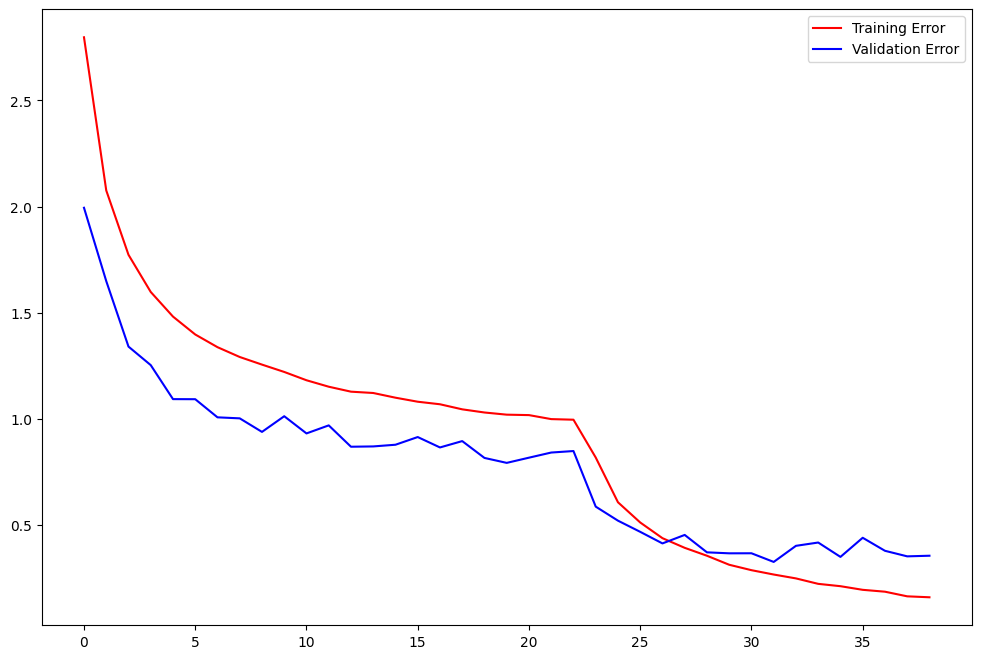

In [20]:
plt.figure(figsize=(12,8))
plt.plot(loss,color='r',label='Training Error')
plt.plot(val_loss, color='b',label='Validation Error')
plt.legend()
plt.show()

### Accuracy Graph

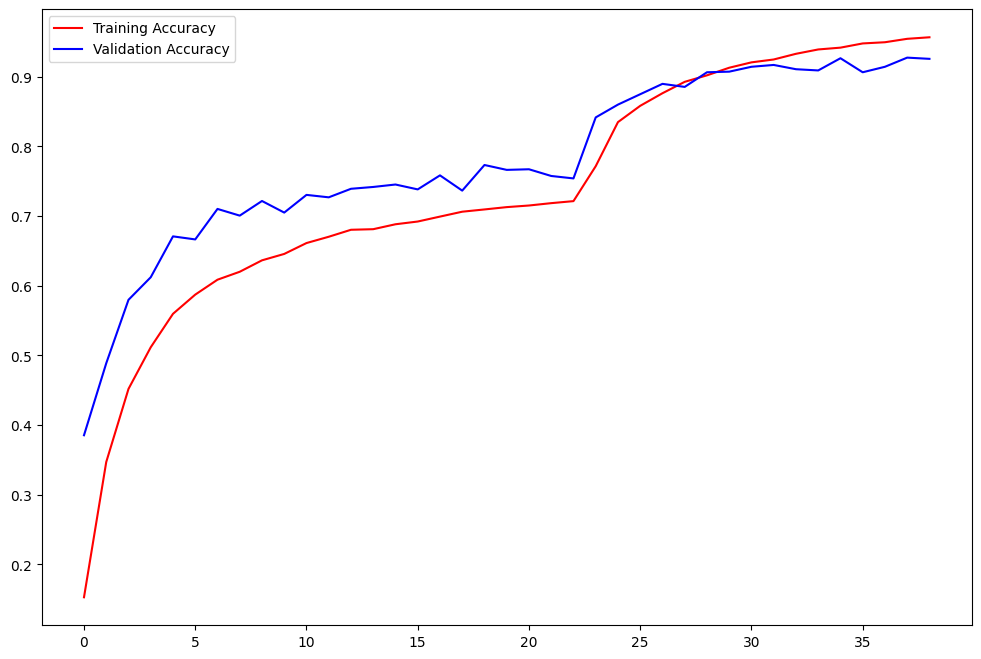

In [21]:
plt.figure(figsize=(12,8))
plt.plot(accuracy,color='r',label='Training Accuracy')
plt.plot(val_accuracy, color='b',label='Validation Accuracy')
plt.legend()
plt.show()

# Plotting the Confusion Matrix

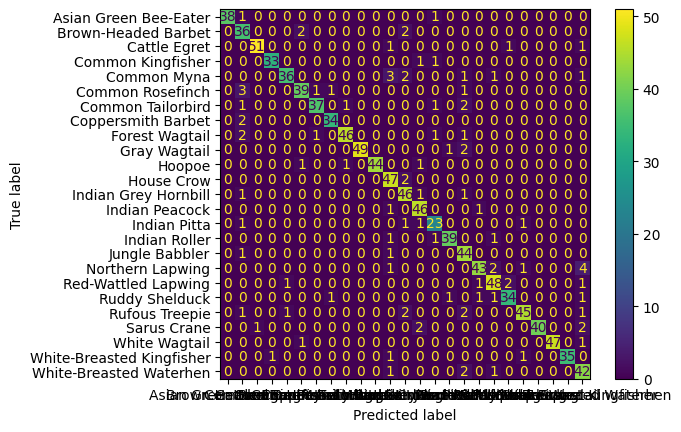

In [22]:
y_true = []
y_predicted = []
bads =[]
images = []
for image,label in test_ds:
    for i in label:
        y_true.append(i.numpy())
    for i in model.predict(image,verbose=0):
        y_predicted.append(np.argmax(i)) 
    for i in image:
        images.append(image)
for i in range(len(images)):
    if y_true[i] != y_predicted[i]:
        bads.append(images[i])
y_true = np.array(y_true)
y_predicted = np.array(y_predicted)
cm = confusion_matrix(y_true, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show()

# Classification Report

In [23]:
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        40
           1       0.73      0.90      0.81        40
           2       0.98      0.94      0.96        54
           3       0.97      0.94      0.96        35
           4       0.95      0.82      0.88        44
           5       0.91      0.87      0.89        45
           6       0.95      0.88      0.91        42
           7       0.94      0.94      0.94        36
           8       0.96      0.90      0.93        51
           9       1.00      0.94      0.97        52
          10       1.00      0.94      0.97        47
          11       0.82      0.96      0.89        49
          12       0.84      0.94      0.88        49
          13       0.88      0.96      0.92        48
          14       0.82      0.85      0.84        27
          15       0.95      0.93      0.94        42
          16       0.79      0.96      0.86        46
          17       0.93    

# Saving the final model

In [24]:
model.save('model.h5')